In [9]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [11]:
len(words)

32033

In [12]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [13]:
# build dataset
block_size = 3
def build_dataset(words):
    X,Y = [],[]
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context),'------>',itos[ix])
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [14]:
#MLP revisited
n_embd = 10 #the dimensioanlity of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd),generator=g)
W1 = torch.randn((n_embd*block_size,n_hidden),generator=g) * (5/3) / ((n_embd * block_size)**0.5)
#b1 = torch.randn(n_hidden,generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size),generator=g) * 0.01
b2 = torch.randn(vocab_size,generator=g) * 0
bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))
bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))
parameters = [C,W1,b1,W2,b2,bngain,bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

NameError: name 'b1' is not defined

In [ ]:
hpreact.std(0,keepdim=True).shape

torch.Size([1, 200])

In [ ]:
max_step = 1000
batch_size = 32
lossi = []
for i in range(max_step):
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb,Yb = Xtr[ix],Ytr[ix]
    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 #+ b1  hpreact - bnmeani 会把b1减掉，因此一开始没必要引入b1，偏置会在批量处理时引入(bnbias)
    bnmeani = hpreact.mean(0,keepdim=True)
    bnstdi = hpreact.std(0,keepdim=True)
    hpreact = bngain *(hpreact -bnmeani ) / bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Yb)
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.1 if i < 500 else 0.01
    for p in parameters:
        p.data += - lr * p.grad
    
    if i % 100 == 0:
        print(f'{i:7d}/{max_step:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/   1000:3.3147
    100/   1000:2.4222
    200/   1000:2.8362
    300/   1000:2.5838
    400/   1000:2.5099
    500/   1000:2.7987
    600/   1000:2.4788
    700/   1000:2.4372
    800/   1000:2.3036
    900/   1000:2.1063


In [ ]:
# calibrate the batch norm at the end of training expilicitly
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 #+ b1
    bnmean = hpreact.mean(0,keepdim=True)
    bnstd = hpreact.std(0,keepdim=True)

In [ ]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr,Ytr),
        'val':(Xdev,Ydev),
        'test':(Xte,Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 #+ b1
    hpreact = bngain * (hpreact -bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,y)
    print(split,loss.item())
split_loss('train')
split_loss('val')

train 2.4530653953552246
val 2.448368787765503


: 

In [ ]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1) #+ b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits,dim=1)
        ix = torch.multinomial(probs,num_samples=1,generator=g).item()
        context = context[1:]+[ix]
        out.append(ix)
        if ix==0:
            break

        print(''.join(itos[i] for i in out))

m
mr
mri
mria
m
mm
mmy
mmya
mmyaz
mmyazh
mmyazhr
mmyazhre
mmyazhree
mmyazhreel
n
nd
ndh
ndhr
ndhri
ndhria
ndhrial
r
re
rem
remm
remmr
remmrs
remmrst
remmrste
remmrsten
remmrstend
remmrstendr
remmrstendrl
remmrstendrle
remmrstendrlen
a
ad
ade
adee
d
di
die
diel
dieli
dielii
s
sh
shy
j
je
jen
e
ed
ede
edei
edeis
edeiso
edeisoa
edeisoan
edeisoana
edeisoanan
edeisoanana
edeisoananar
edeisoananara
edeisoananarae
edeisoananarael
edeisoananaraely
k
ko
koh
kohl
kohla
kohlar
kohlara
n
no
nos
nosa
nosad
nosadb
nosadbe
nosadber
nosadberg
nosadbergi
nosadbergih
nosadbergihi
j
je
jes
jest
j
ja
jah
jahr
jahre
jahren
jahrene
jahrenel
jahrenele
jahrenelel
jahrenelela
jahrenelelan
p
pu
puo
puof
u
uo
uor
uore
uoren
d
da
dar
dari
dariy
j
ju
jue
e
eh
ehs
k
ka
kay
m
my
mys
myst
mystn
mystny
mystnyl
mystnyla


目前还有几个问题：
1. 初始化的时候loss太高了，我们尽量让W2小一点，可以在生成的矩阵上*0.01，让b2为0，效果就会很好，不会急剧下降。
2. tanh会集中输出-1和1，从而在方向传播的时候出现梯度损失的情况。如果在此之后梯度一直损失，神经元就永久坏死了，这是我们需要避免的。我们可用Leaky-ReLU解决，因为这个函数无论何时都有斜率，没有平坦的地方。

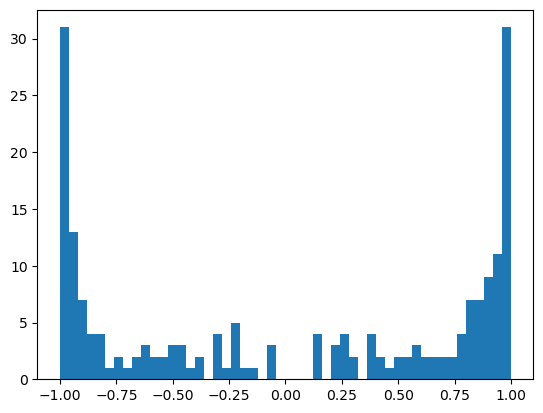

In [ ]:
plt.hist(h.view(-1).tolist(),50)
plt.show()

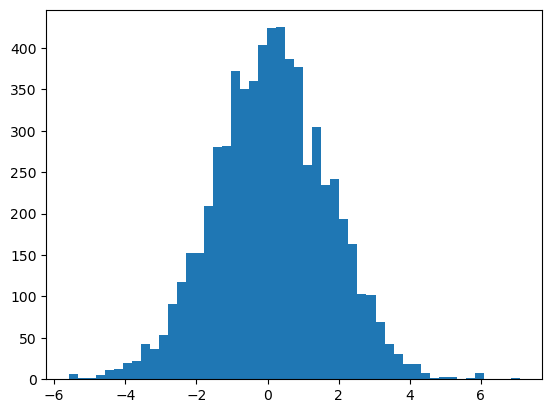

In [ ]:
plt.hist(hpreact.view(-1).tolist(),50)
plt.show()

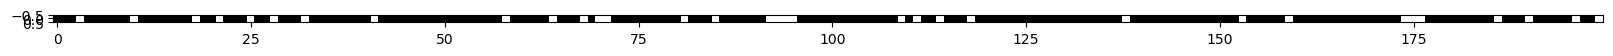

In [ ]:
plt.figure(figsize=(20,10));
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest');
plt.show()

tensor(0.0245) tensor(0.9984)
tensor(-0.0080) tensor(0.9976)


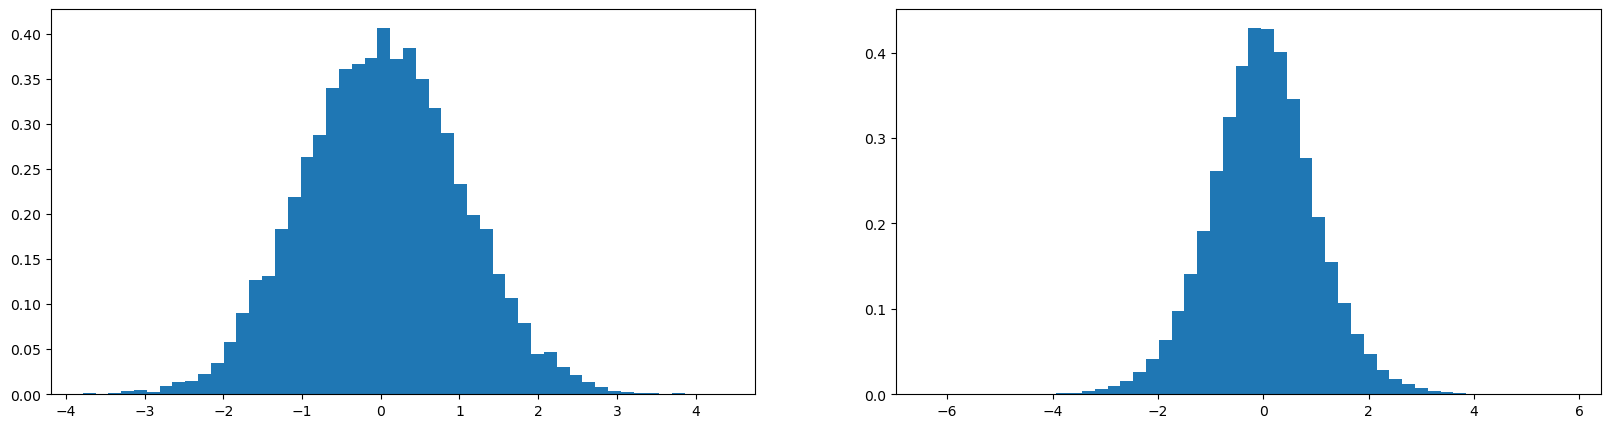

In [ ]:
x = torch.randn(1000,10)
w = torch.randn(10,200) / 10 **0.5
y = x @ w
print(x.mean(),x.std())
print(y.mean(),y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(),50,density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(),50,density=True);
plt.show()

强烈建议有空了看看HeKaiMing的论文Delving Into ICCV。里面讲了如何初始化能够平衡非线性函数对标准差的影响。同时，torch里有函数torch.nn.init.kaiming_model，可以去看看官方文档。简而言之，要在矩阵后面额外$\times \frac{gain}{\sqrt(number of element)}$。对于tanh而言，gain是5/3。

谷歌有篇论文，对于隐藏层，我们可以手动归一化，也就是手动调整为正态分布，因为这个操作是完全可微分的。即 $\frac{x-\mu}{\sigma}$。批量归一化引入不确定性反而增强了数据，是一种正则化手段，使得过拟合更难。

In [ ]:
# SUMMARY-------

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
words = open('names.txt','r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [6]:
# build dataset
block_size = 3
def build_dataset(words):
    X,Y = [],[]
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context),'------>',itos[ix])
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [49]:
# let's train a deeper network

class Linear:
    def __init__(self,fan_in,fan_out,bias=True):
        self.weight = torch.randn((fan_in,fan_out),generator=g) #/ fan_in **0.5
        self.bias = torch.zeros(fan_out) if bias else None
    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self,dim,eps=1e-5,momentum=0.1):
        self.eps = eps
        self.momentum  = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    def __call__(self,x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0,keepdim=True)
            xvar = x.var(0,keepdim=True,unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean) / torch.sqrt(xvar+self.eps)
        self.out = self.gamma * xhat + self.beta
        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum)*self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum)*self.running_var + self.momentum * xvar
        return self.out
    def parameters(self):
        return [self.gamma,self.beta]

class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C=torch.randn((vocab_size,n_embd),generator=g)
layers = [
    Linear(n_embd*block_size,n_hidden),BatchNorm1d(n_hidden),Tanh(),
    Linear(         n_hidden,n_hidden ),BatchNorm1d(n_hidden),Tanh(),
    Linear(         n_hidden,n_hidden ),BatchNorm1d(n_hidden),Tanh(),
    Linear(         n_hidden,n_hidden ),BatchNorm1d(n_hidden),Tanh(),
    Linear(         n_hidden,n_hidden ),BatchNorm1d(n_hidden),Tanh(),
    Linear(         n_hidden,vocab_size),BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # last layer:make less confident
    # layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1
    #all pther layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer,Linear):
            layer.weight *= 1.0 #5/3
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True
    

47551


In [55]:
max_step = 1000
batch_size = 32
lossi = []
ud = []
for i in range(max_step):
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb,Yb = Xtr[ix],Ytr[ix]
    emb = C[Xb]
    x = emb.view(emb.shape[0],-1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x,Yb)
    
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.6 
    for p in parameters:
        p.data += - lr * p.grad
    
    if i % 100 == 0:
        print(f'{i:7d}/{max_step:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])

      0/   1000:2.5757
    100/   1000:2.6499
    200/   1000:2.7130
    300/   1000:2.6551
    400/   1000:2.3472
    500/   1000:2.3956
    600/   1000:2.5691
    700/   1000:2.3666
    800/   1000:2.2378
    900/   1000:2.5715


layer 2 (      Tanh): mean -0.00, std 0.62 , saturated: 3.06%
layer 5 (      Tanh): mean -0.01, std 0.63 , saturated: 2.88%
layer 8 (      Tanh): mean -0.03, std 0.63 , saturated: 2.97%
layer 11 (      Tanh): mean -0.02, std 0.63 , saturated: 3.28%
layer 14 (      Tanh): mean +0.02, std 0.64 , saturated: 2.69%


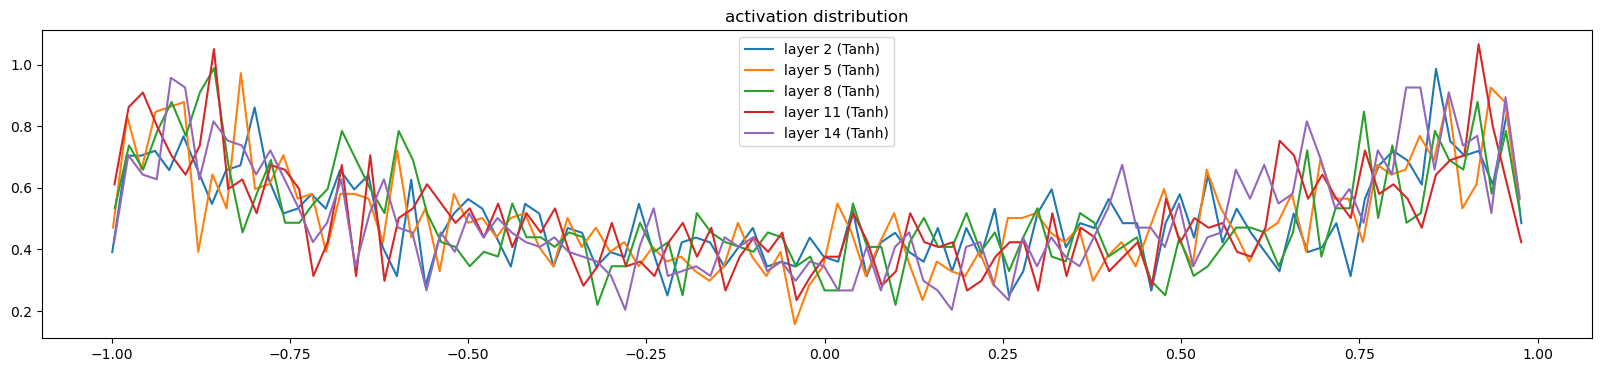

In [56]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i,layer in enumerate(layers[:-1]):
    if isinstance(layer,Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f , saturated: %.2f%%' % (i,layer.__class__.__name__,t.mean(),t.std(),(t.abs()>0.97).float().mean()*100))
        hy,hx = torch.histogram(t,density=True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')
plt.show()

layer 2 (      Tanh): mean -0.00, std 4.644773e-03
layer 5 (      Tanh): mean -0.00, std 4.085224e-03
layer 8 (      Tanh): mean -0.00, std 4.162377e-03
layer 11 (      Tanh): mean +0.00, std 3.714573e-03
layer 14 (      Tanh): mean -0.00, std 3.566271e-03


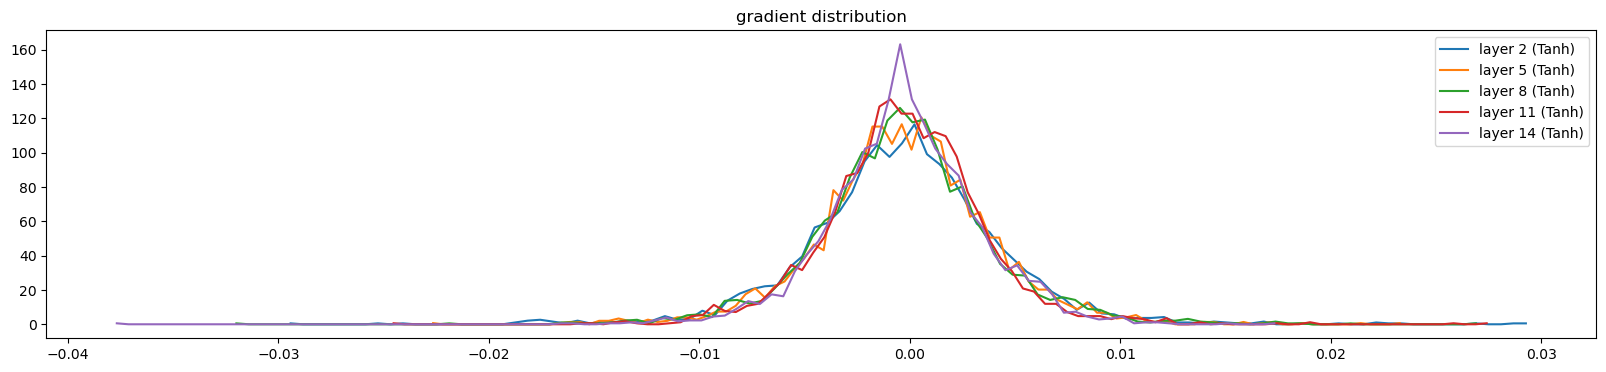

In [57]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i,layer in enumerate(layers[:-1]):
    if isinstance(layer,Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %e' % (i,layer.__class__.__name__,t.mean(),t.std()))
        hy,hx = torch.histogram(t,density=True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distribution')
plt.show()

weight   (27, 10) | mean -0.000000 | std 1.071491e-02 | grad:data ratio 1.057226e-02
weight  (30, 100) | mean +0.000082 | std 3.263446e-03 | grad:data ratio 3.180510e-03
weight (100, 100) | mean -0.000069 | std 1.586548e-03 | grad:data ratio 1.591248e-03
weight (100, 100) | mean +0.000007 | std 1.424839e-03 | grad:data ratio 1.414142e-03
weight (100, 100) | mean -0.000015 | std 1.367840e-03 | grad:data ratio 1.363316e-03
weight (100, 100) | mean -0.000021 | std 1.292790e-03 | grad:data ratio 1.287314e-03
weight  (100, 27) | mean +0.000027 | std 2.162895e-03 | grad:data ratio 2.186195e-03


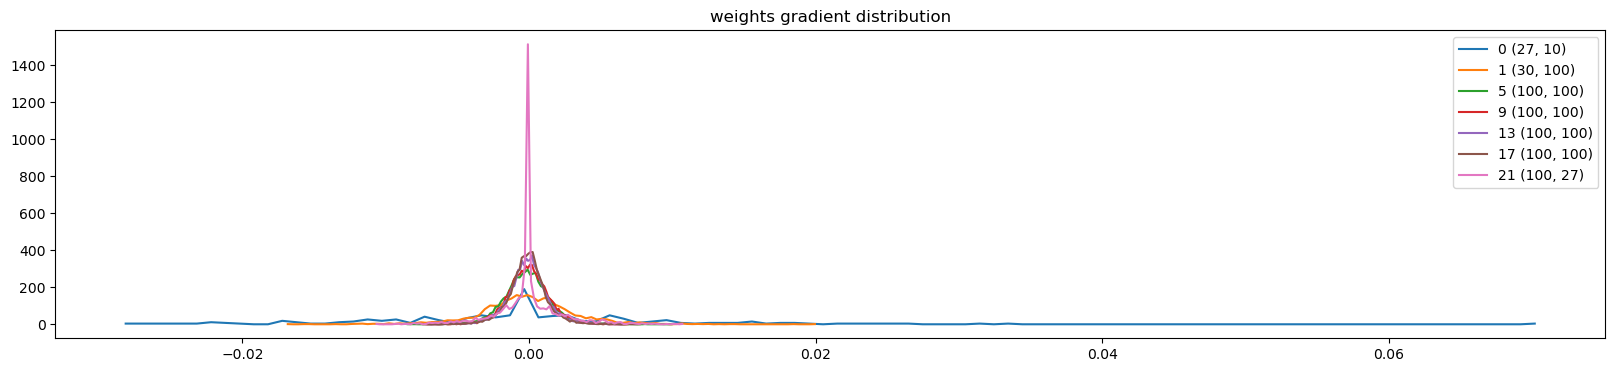

In [58]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');
plt.show()

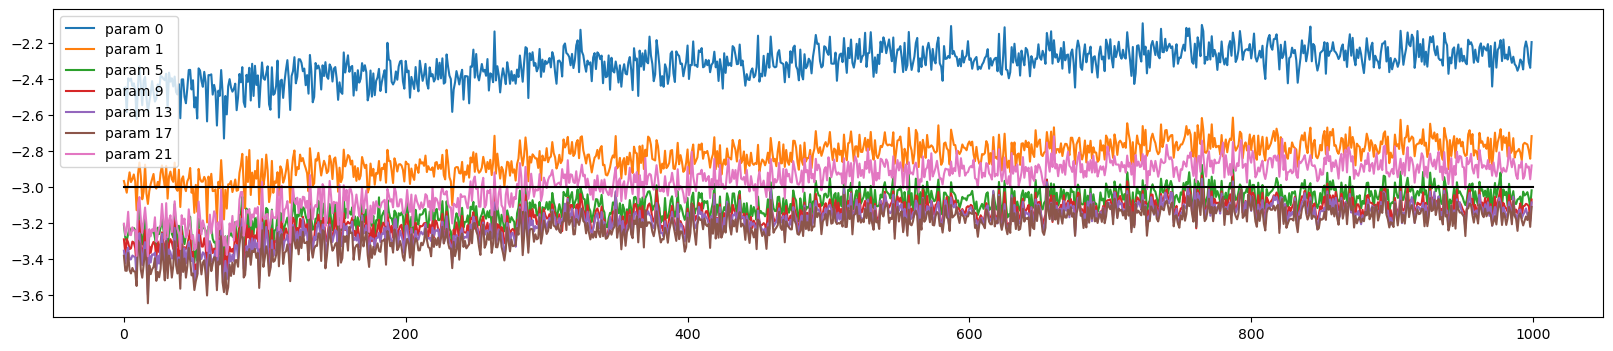

In [59]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
plt.show()